# Quiz 1: Calibration - Intrinsics and Extrinsics Parameters 

Students:

* **Eugênio Pacceli**
* **Renato Oliveira**
* **Brayan Acevedo**

We implemented the algorithm presented in the chapter 6 of the book *"Introductory Techniques For 3D Computer Vision"*, written by Trucco and Verri.

Given the images of the calibration board, and the dimensions of each of it's squares (dx=23.5mm and dy=23.5mm), the first step of the algorithm is to compute the coordinates of each square corner, having 6 of those on the X axis, and 8 in the Y axis.

These corners have their coordinates [X, Y, Z] representing their positions on the real world. Considering the board represents a single plane and only the camera moves, we have Z = 0 for all those corners.

---

**Initialize program**
* Read each image file, using OpenCv.
* Define the board parameters and it's representation as a matrix.

In [134]:
import os
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

REALSQUARE = 23.500 # Size of a square
BOARDDIM = (6,8) # Dimensions of the given board
NUMIMG = 9 # Number of images to open
imagesList = list()

# Opens each image and adds to the image list
PATH = "quiz1-data/"
for fileName in os.listdir(PATH):
    imagesList.append(cv2.imread(PATH + fileName, 0))

# Computes the real world coordinates of each beginning of a square in the board  
realSquares = []
for i in range(BOARDDIM[1]):
    for j in range(BOARDDIM[0]):
        realSquares.append([j*REALSQUARE, i*REALSQUARE, 0.000])

# Converts to numpy array
realSquares = np.array(realSquares, dtype=np.float32)


**Detect the corners on the real images and compute A matrix**

To detect the corners of each square in each image, we used the function ```findChessboardCorners()```, from OpenCv.

This function returns every corner found in an image, given the board dimensions in the real world (6,8).

So, for every image, we executed this function and associated each corner [x,y], found on each image, with it's equivalent in the real world coordinates [X,Y,Z].

Then we calculated all the rows of the **A** matrix, given the association between real world coordinates and image plane coordinates for every corner.

In [135]:
matA = list()

for item in range(NUMIMG):
    img = imagesList[item]
    _, boardCorners = cv2.findChessboardCorners(img, BOARDDIM, None)
    boardCorners = boardCorners.reshape((BOARDDIM[0] * BOARDDIM[1], 2))
    for k in range(48):
        x, y = boardCorners[k, :]
        X, Y, Z = realSquares[k, :]
        matA.append([x*X, x*Y, x*Z, x, -y*X, -y*Y, y*Z, -y])

Now we must compute the parameters of the rotation matrix **R** and translation vector **T**, given the results of the SVD (singular values decomposition) of matrix **A** (remember this matrix was generated, in the loop above, using the product of each square corner real coordinates by it's image plane coordinates, plus a column with -y in the end of each row of **A**).

First, lets obtain the **v** vector:
* v[1] = r[2,1]
* v[2] = r[2,2]
* v[3] = r[2,3]
* v[4] = Ty
* v[5] = a\*r[1,1]
* v[6] = a\*r[1,2]
* v[7] = a\*r[1,3]
* v[8] = a\*Tx

r[x,y] are the elements of **R** matrix, Ty and Tx are the elements of **T** vector, 'a' is the ration between the numbers of pixels on a image horizontal line by vertical line (aspect ratio).

To obtain the **v** vector of the equation **Av**=0, we did the singular values decomposition using the function ```numpy.linalg.svd()```, which returns **U**, **D**, **V**.

The vector-solution **v** is obtained by extracting the column of **V** corresponding to the column of **D** that contains the minimal value in the diagonal.

In [136]:
matA = np.array(matA, dtype=np.float32)

U, D, V = np.linalg.svd(matA, full_matrices=True)

# The column of V corresponding to the minimal value in the diagonal of D
# In the given sample, D always contains a 0 in  the 7th columny
# If we pick another value, v is generated with null values
vecV = V[6,:]

v1, v2, v3, v4, v5, v6, v7, v8 = vecV


Scale factor = sqrt(r[2,1]^2 + r[2,2]^2 + r[2,3]^2)

In [137]:
# Compute the scale factor given the vector v
gamma = np.sqrt(v1**2 + v2**2 + v3**2)

Aspect ratio = sqrt(v[5]^2 + v[6]^2 + v[7]^2) / Scale factor

In [138]:
# Compute the aspect ratio (alpha)
alpha = np.sqrt(v5**2 + v6**2 + v7**2) / gamma

Extraction of rotation matrix **R** and translation vector **T** given the elements of **v** vector:

In [139]:
# First row of R matrix
r11, r12, r13 = [v5 / alpha, v6 / alpha, v7 / alpha]

# Second row of R matrix
r21, r22, r23 = v1/gamma, v2/gamma, v3/gamma

# Third row of R matrix, computed by the cross product of rows 1 and 2
r31, r32, r33 = np.cross([r11, r12, r13], [r21, r22, r23])

# Obtain the elements of the translation vector
Tx, Ty = [v8/alpha, v4]

Determinate the signal of gamma, to detect a possible signal inversion of the first two rows of **R** matrix.

Then, we compute the parameters Tz and fx, creating another matrix **A** and a vector **B**, and solving the equation system using the least squares technique, made available by the function ```np.linalg.lstsq(matA,vecB)```.

In [140]:
# If this product is bigger than 0, invert the signal on R[1,:] and R[2,:]
if x*(r11*X + r12*Y + r13*Z + Tx) > 0:
    r11 = -r11
    r12 = -r12
    r13 = -r13
    r21 = -r21
    r22 = -r22
    r23 = -r23
    Tx = -Tx
    Ty = -Ty

del matA
matA = list()
vecB = list()

# Generate new matrix A and vector B
for item in range(NUMIMG):
    _, boardCorners = cv2.findChessboardCorners(imagesList[item], BOARDDIM, None)
    boardCorners = boardCorners.reshape((BOARDDIM[0] * BOARDDIM[1], 2))
    for k in range(48):
        x, y = boardCorners[k, :]
        X, Y, Z = realSquares[k]
        matA.append([x, (r11*X + r12*Y + r13*Z + Tx)])
        vecB.append([-x*(r31*X + r32*Y + r33*Z)])

matA = np.array(matA)
vecB = np.array(vecB)
# Solve by least squares the system Ax = B
vecSol,_, _, _ = np.linalg.lstsq(matA,vecB)

# Obtain Tz and fx
Tz, fx = vecSol

# Compute fy
fy =  fx / alpha

# Matrix R and vector T representation in proper numpy objects
matR = np.array([[r11, r12, r13], [r21, r22, r23], [r31, r32, r33]])
vecT = np.array([[Tx], [Ty], [Tz]])

**Prints our results**

In [141]:
print("Matriz R \n {}".format(matR))
print("\nVetor T\n{}".format(vecT))
print("fx = {}".format(fx))
print("fy ={}".format(fy))
print("alpha = {}".format(alpha))
print("gamma = {}".format(gamma))

Matriz R 
 [[ -9.50863082e-01   3.09611690e-01   0.00000000e+00]
 [ -1.04558329e-16   1.33305397e-16  -1.00000000e+00]
 [ -3.09611690e-01  -9.50863082e-01  -9.43826993e-17]]

Vetor T
[[ -1.88000108e-01]
 [ -8.01168654e-15]
 [  1.23066928e+02]]
fx = [ 238.25718033]
fy =[  1.39354624e+18]
alpha = 1.70971851617e-16
gamma = 1.0


## Results given by the Toolbox using Matlab 

% Intrinsic and Extrinsic Camera Parameters
%
% This script file can be directly executed under Matlab to recover the camera intrinsic and extrinsic parameters.
% IMPORTANT: This file contains neither the structure of the calibration objects nor the image coordinates of the calibration points.
%            All those complementary variables are saved in the complete matlab data file Calib_Results.mat.
% For more information regarding the calibration model visit http://www.vision.caltech.edu/bouguetj/calib_doc/

### Intrinsic Camera Parameters


#### %-- Focal length: 
fc = [ 1319.360839018184800 ; 1325.862886727936900 ];

#### %-- Principal point:
cc = [ 801.687461000126630 ; 398.685724393203370 ];

%-- Skew coefficient:
alpha_c = 0.000000000000000;

#### %-- Distortion coefficients:
kc = [ 0.094052171503048 ; -0.196804510414059 ; -0.009826260896323 ; 0.003042938250442 ; 0.000000000000000 ];

%-- Focal length uncertainty:
fc_error = [ 7.614776975212465 ; 7.882743402506637 ];

%-- Principal point uncertainty:
cc_error = [ 10.631216021613728 ; 10.799630586885627 ];

%-- Skew coefficient uncertainty:
alpha_c_error = 0.000000000000000;

#### %-- Distortion coefficients uncertainty:
kc_error = [ 0.022911520624474 ; 0.089089522533125 ; 0.002827995432640 ; 0.003450888593813 ; 0.000000000000000 ];

%-- Image size:
nx = 1600;
ny = 904;


%-- Various other variables (may be ignored if you do not use the Matlab Calibration Toolbox):
%-- Those variables are used to control which intrinsic parameters should be optimized

n_ima = 9;						    % Number of calibration images
est_fc = [ 1 ; 1 ];					% Estimation indicator of the two focal variables
est_aspect_ratio = 1;				% Estimation indicator of the aspect ratio fc(2)/fc(1)
center_optim = 1;					% Estimation indicator of the principal point
est_alpha = 0;						% Estimation indicator of the skew coefficient
est_dist = [ 1 ; 1 ; 1 ; 1 ; 0 ];	% Estimation indicator of the distortion coefficients

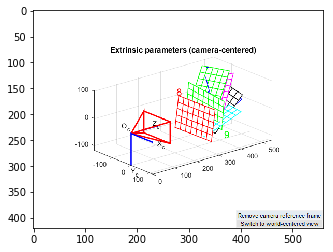

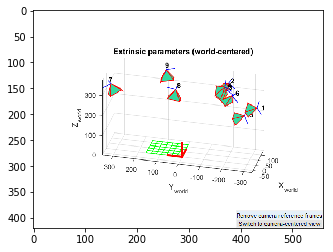

In [142]:
img1w = cv2.imread('extrin_param.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(1)
plt.imshow(img_rgb)

img1w = cv2.imread('extrin_param1.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(2)
plt.imshow(img_rgb)


### Extrinsic Camera Parameters

%-- The rotation (omc_kk) and the translation (Tc_kk) vectors for every calibration image and their uncertainties

##### %-- Image #1:
omc_1 = [ 1.984622e+00 ; 1.845352e-01 ; 2.870369e-01 ];

Tc_1  = [ -1.574390e+02 ; 5.101294e+01 ; 3.756956e+02 ];

omc_error_1 = [ 8.027448e-03 ; 4.932236e-03 ; 8.087287e-03 ];

Tc_error_1  = [ 3.093133e+00 ; 3.203087e+00 ; 2.546667e+00 ];

##### %-- Image #2:
omc_2 = [ 2.508173e+00 ; -2.174940e-01 ; 2.164566e-01 ];

Tc_2  = [ -1.390132e+02 ; 6.165338e+01 ; 3.904267e+02 ];

omc_error_2 = [ 8.521395e-03 ; 3.432194e-03 ; 1.065160e-02 ];

Tc_error_2  = [ 3.169612e+00 ; 3.282157e+00 ; 2.471550e+00 ];

##### %-- Image #3:
omc_3 = [ 2.527412e+00 ; -1.619762e-01 ; 2.726591e-01 ];

Tc_3  = [ -1.320341e+02 ; 3.732533e+01 ; 3.677618e+02 ];

omc_error_3 = [ 8.562994e-03 ; 3.575236e-03 ; 1.069876e-02 ];

Tc_error_3  = [ 2.971579e+00 ; 3.088936e+00 ; 2.324621e+00 ];

##### %-- Image #4:
omc_4 = [ 2.403292e+00 ; 2.859610e-01 ; 3.590933e-01 ];

Tc_4  = [ -1.307800e+02 ; 6.399676e+01 ; 3.768658e+02 ];

omc_error_4 = [ 8.352029e-03 ; 3.534587e-03 ; 9.799631e-03 ];

Tc_error_4  = [ 3.104473e+00 ; 3.162434e+00 ; 2.366463e+00 ];

##### %-- Image #5:
omc_5 = [ 1.950385e+00 ; 8.878343e-02 ; -3.789958e-02 ];

Tc_5  = [ -8.674013e+01 ; 7.116935e+01 ; 3.170839e+02 ];

omc_error_5 = [ 7.936524e-03 ; 4.988629e-03 ; 8.027915e-03 ];

Tc_error_5  = [ 2.598114e+00 ; 2.646435e+00 ; 2.018596e+00 ];

##### %-- Image #6:
omc_6 = [ 2.396903e+00 ; -5.169785e-01 ; 4.419722e-02 ];

Tc_6  = [ -8.462341e+01 ; 5.978167e+01 ; 3.749603e+02 ];

omc_error_6 = [ 8.379910e-03 ; 3.952135e-03 ; 1.001740e-02 ];

Tc_error_6  = [ 3.031554e+00 ; 3.096359e+00 ; 2.264016e+00 ];

##### %-- Image #7:
omc_7 = [ 2.472130e+00 ; -1.340944e+00 ; -3.767778e-01 ];

Tc_7  = [ -7.211444e+01 ; 1.104529e+02 ; 3.959351e+02 ];

omc_error_7 = [ 8.504043e-03 ; 3.186557e-03 ; 1.220480e-02 ];

Tc_error_7  = [ 3.256782e+00 ; 3.260764e+00 ; 2.366755e+00 ];

##### %-- Image #8:
omc_8 = [ -2.244006e+00 ; 2.066472e+00 ; -2.738894e-01 ];

Tc_8  = [ 5.965238e+01 ; 8.676875e+01 ; 3.136598e+02 ];

omc_error_8 = [ 6.038871e-03 ; 5.565660e-03 ; 1.031145e-02 ];

Tc_error_8  = [ 2.556427e+00 ; 2.563756e+00 ; 1.969765e+00 ];

##### %-- Image #9:
omc_9 = [ -2.292830e+00 ; 1.862245e+00 ; -4.464243e-02 ];

Tc_9  = [ 2.162723e+01 ; 7.229592e+01 ; 3.928030e+02 ];

omc_error_9 = [ 6.143239e-03 ; 5.905689e-03 ; 1.211607e-02 ];

Tc_error_9  = [ 3.168044e+00 ; 3.163959e+00 ; 2.144994e+00 ];

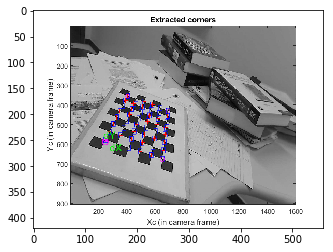

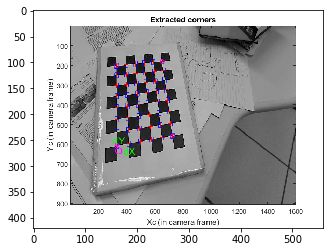

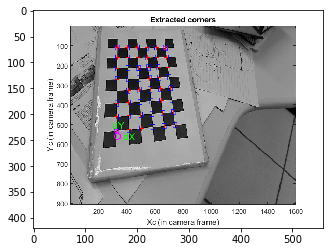

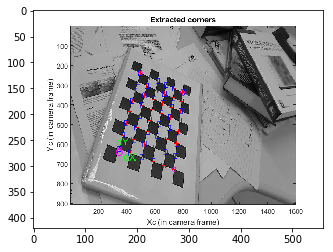

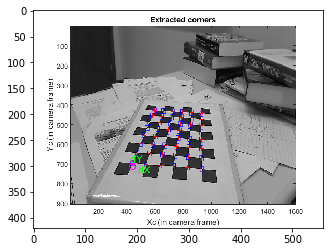

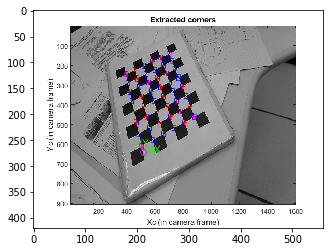

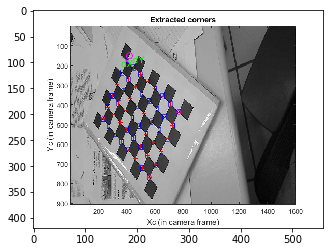

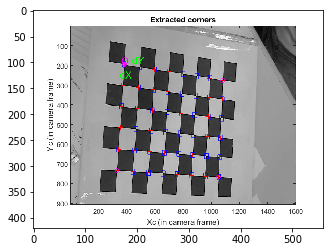

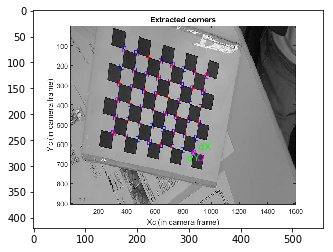

In [143]:
img1w = cv2.imread('corner_1.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(1)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_2.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(2)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_3.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(3)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_4.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(4)
plt.imshow(img_rgb)
img1w = cv2.imread('corner_5.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(5)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_6.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(6)
plt.imshow(img_rgb)
img1w = cv2.imread('corner_7.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(7)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_8.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(8)
plt.imshow(img_rgb)

img1w = cv2.imread('corner_9.png', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img1w, cv2.COLOR_BGR2RGB)
plt.figure(9)
plt.imshow(img_rgb)

Sources:

* [Camera calibration with OpenCv](http://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html)
* Introductory techniques for 3-D computer vision - Emanuele Trucco & Alessandro Verri, Capítulo 6 "Camera Calibration"

---